In [ ]:
import findspark

findspark.init()

import sys
from pathlib import Path

sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")


In [ ]:
from pyspark.sql.functions import hour, dayofweek, month, year, when

df = df.withColumn("hour_of_day", hour(df["Start_Time"]))
df = df.withColumn("day_of_week", dayofweek(df["Start_Time"]))
df = df.withColumn("month", month(df["Start_Time"]))
df = df.withColumn("year", year(df["Start_Time"]))

df = df.withColumn("weather_condition_cat", when(df["Weather_Condition"] == "Clear", 0)
                                            .when(df["Weather_Condition"] == "Rain", 1)
                                            .when(df["Weather_Condition"] == "Snow", 2)
                                            .otherwise(3))

df = df.withColumn("is_night", when((df["hour_of_day"] >= 18) | (df["hour_of_day"] < 6), 1).otherwise(0))

df = df.withColumn("severe_accident", when(df["Severity"] >= 3, 1).otherwise(0))

df.show(5)


+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+-----+----+---------------------+--------+---------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visib

In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=["Temperature(F)", "Wind_Speed(mph)", "Humidity(%)"], outputCols=["Temperature_imputed", "Wind_Speed_imputed", "Humidity_imputed"])
df = imputer.fit(df).transform(df)

df = df.dropna(subset=["Severity"])

In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

logistic_features = ["hour_of_day", "day_of_week", "month", "Temperature_imputed", "Wind_Speed_imputed", "Humidity_imputed", "is_night", "weather_condition_cat"]
assembler = VectorAssembler(inputCols=logistic_features, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

lr_model = LogisticRegression(labelCol="severe_accident", featuresCol="features")
model = lr_model.fit(train_data)

logistic_predictions = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(logistic_predictions)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

precision_evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(logistic_predictions)
recall = recall_evaluator.evaluate(logistic_predictions)
f1 = f1_evaluator.evaluate(logistic_predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Logistic Regression Accuracy: 0.81
Precision: 0.73
Recall: 0.81
F1-Score: 0.72


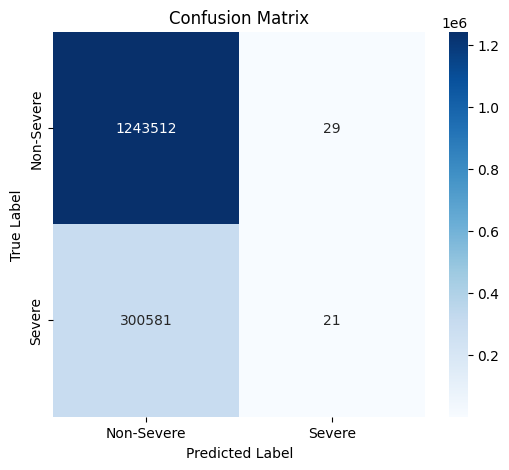

In [ ]:
predictions_df = logistic_predictions.select("severe_accident", "prediction").toPandas()

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(predictions_df["severe_accident"], predictions_df["prediction"])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Severe", "Severe"], yticklabels=["Non-Severe", "Severe"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

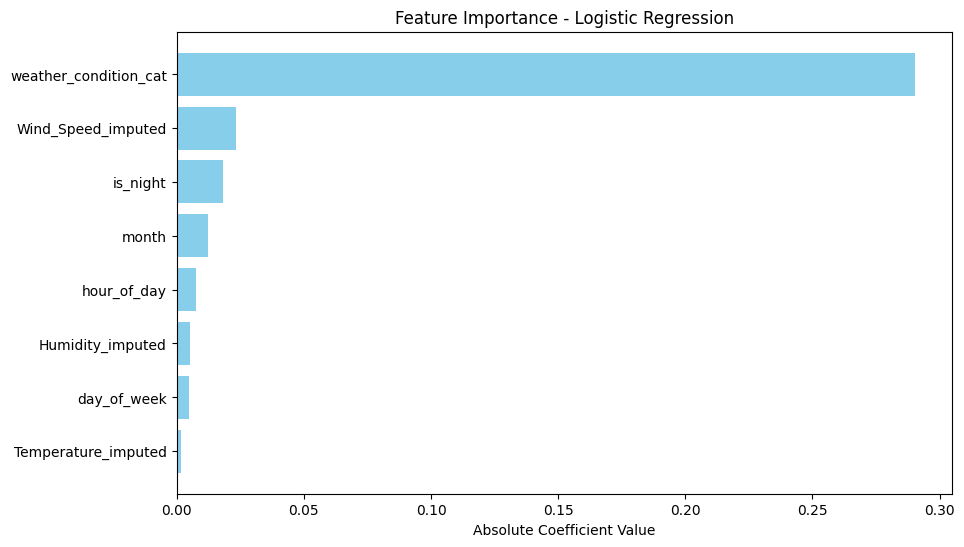

                 Feature  Coefficient
7  weather_condition_cat    -0.290270
4     Wind_Speed_imputed     0.023321
6               is_night     0.018237
2                  month    -0.012177
0            hour_of_day     0.007413
5       Humidity_imputed     0.005141
1            day_of_week    -0.004697
3    Temperature_imputed     0.001640


In [10]:
from pyspark.ml.classification import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt

coefficients = model.coefficients.toArray()
intercept = model.intercept
features = logistic_features

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance - Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df[['Feature', 'Coefficient']])

